In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

from mrs_denoising import denoising

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Assessment of LP variance estimation approaches on toy single peak model
The construction of the Hankel matrix in the LP denoising case  results in noise characteristics that violate the i.i.d. zero-mean Gaussian assumptions in Chen et al. Does this matter?

## Define local functions as in single_peak_st_lp_lora.ipynb
### Data model
The toy data model is a single unit-amplitude on-resonance Lorentzian peak with a fwhm (in Hz) of $1/\pi\alpha$. This is modeled in the time domain as a exponentially decaying sinusoid with Gaussian noise. Following the notation of Cavassila _et al_(1):

$$x_n =  \hat{x}_n + b_n,\;\; b_n\stackrel{\mathrm{iid}}{\sim}\mathcal{N}(0,\sigma^2)$$  
$$\hat{x}_n =  \sum_{k=1}^K c_k \exp((\alpha_k+j\omega_k)nt_s)\exp(j\phi_k)$$

Here, in this toy model: $K=1, c_k = 1, \omega_k=0$ and $\phi_k=0$.


1. [Cramér-Rao Bound Expressions for Parametric Estimation of Overlapping Peaks: Influence of Prior Knowledge](https://www.sciencedirect.com/science/article/pii/S1090780799920025)

In [3]:
def fwd(x, c, alpha, omega, phi):
    return c * np.exp((alpha + 1j * omega) * x) * np.exp(1j * phi)

def generate_data(sigma, reps=1, linewidth=10, bandwidth=1000, points=512):
    dwelltime = 1 / bandwidth
    time_axis = np.arange(0.0, points*dwelltime, dwelltime)
    
    alpha = -np.pi * linewidth
    noiseless = fwd(time_axis, 1.0, alpha, 0.0, 0.0)
    
    noise = sigma/np.sqrt(2) * np.random.randn(reps,points)\
        + 1j * sigma/np.sqrt(2) * np.random.randn(reps,points)
    
    return noise + noiseless

### Fit functions
Fit the data using non-linear least square optimiser, i.e. a simplified AMARES approach.

In [4]:
def fit_func(x, c, l, o, p):
    cmplx = fwd(x[:int(x.size/2)], c, -np.pi*l, o, p)
    return np.concatenate((cmplx.real, cmplx.imag))

def fit_data(xdata, ydata):
    x0 = [1.0, 30.0, 0.0, 0.0]
    ydat = np.concatenate((ydata.real, ydata.imag))
    xdat = np.concatenate((xdata,xdata))
    xopt, xcov = curve_fit(fit_func, xdat, ydat, p0=x0)
    crlb = np.sqrt(np.diag(xcov))
                               
    return xopt, crlb

### Utility functions

In [5]:
def FID2Spec(FID, axis=0):
    # By convention the first point of the fid is special-cased
    ss = [slice(None) for i in range(FID.ndim)]
    ss[axis] = slice(0, 1)
    ss = tuple(ss)
    FID[ss] *= 0.5
    out = np.fft.fftshift(
        np.fft.fft(FID,
                   axis=axis,
                   norm='ortho'),axes=axis)
    FID[ss] *= 2
    return out

## Make some data
### An example plot

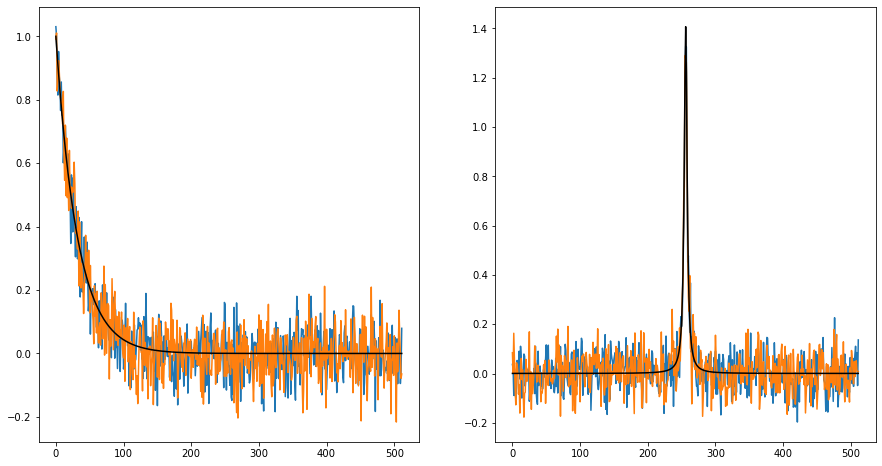

In [6]:
data = generate_data(0.1, reps=2)
data_noiseless = generate_data(0.0)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
ax1.plot(data.T.real)
ax1.plot(data_noiseless.T.real,'k')

ax2.plot(FID2Spec(data.T).real)
ax2.plot(FID2Spec(data_noiseless.T).real,'k')
plt.show()

### Example fit

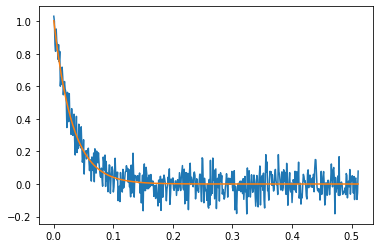

amplitude = 1.00±0.02
linewidth = 10.16±0.35
omega = 1.26±1.10
phi = -0.01±0.02


In [7]:
dwelltime = 1 / 1000
points = 512
t_axis = np.arange(0.0, points*dwelltime, dwelltime)

xout, x_sd = fit_data(t_axis, data[0,:])

c, l, o, p = xout

plt.plot(t_axis,data[0,:].real)
plt.plot(t_axis,fwd(t_axis,c, -np.pi*l, o, p).real)
plt.show()
print(f'amplitude = {c:0.2f}±{x_sd[0]:0.2f}')
print(f'linewidth = {l:0.2f}±{x_sd[1]:0.2f}')
print(f'omega = {o:0.2f}±{x_sd[2]:0.2f}')
print(f'phi = {p:0.2f}±{x_sd[3]:0.2f}')

### Now more repetitions for the evaluation of the denoising
Construct noisy data with a number of 'voxels' and Monte Carlo repeats

In [8]:
data_shape = (8,8,1)
mc_rep = 40
noisy_data = generate_data(0.1, reps=np.prod(data_shape) * mc_rep)
noisy_data = noisy_data.reshape((mc_rep,) + data_shape + (512,))
noisy_data.shape

(40, 8, 8, 1, 512)

## Qualitatively evaluate variance after each type of denoising
### Run the denoising on the noisy data generated above
The next cell takes a little while to run

In [70]:
# LP denoising, rank = 1
lp_denoised = [denoising.lp(nd,1) for nd in noisy_data]
lp_denoised = np.asarray(lp_denoised)

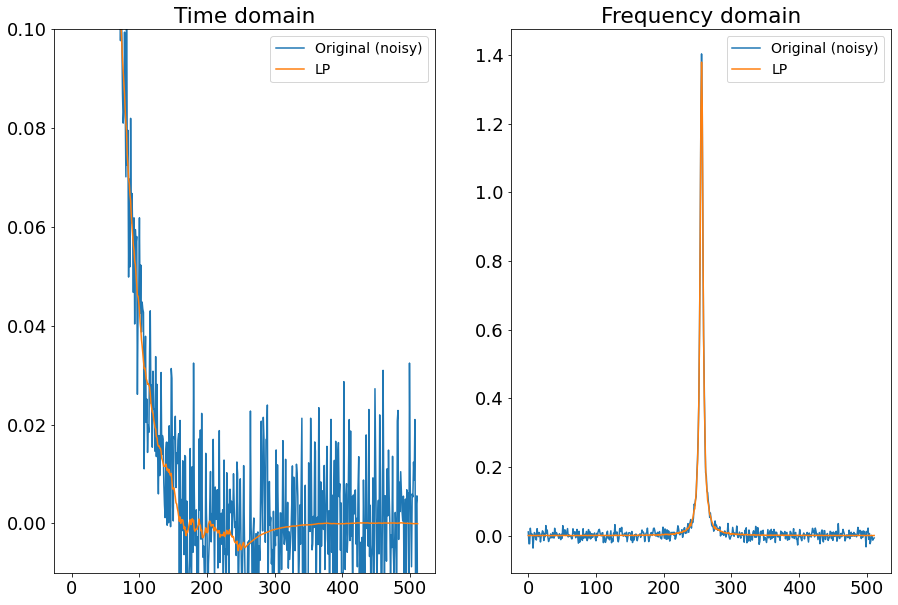

In [68]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
ax1.plot(np.mean(noisy_data[:,6,6,0,:],axis=0).real, label='Original (noisy)')
ax1.plot(np.mean(lp_denoised[:,6,6,0,:],axis=0).real, label='LP')
ax1.set_title('Time domain')
ax1.set_ylim([-0.01, 0.1])
ax1.legend()
ax2.plot(np.mean(FID2Spec(noisy_data,axis=4)[:,6,6,0,:],axis=0).real, label='Original (noisy)')
ax2.plot(np.mean(FID2Spec(lp_denoised,axis=4)[:,6,6,0,:],axis=0).real, label='LP')
ax2.legend()
ax2.set_title('Frequency domain')
plt.show()

### Plot the Monte Carlo standard deviation as a function of frequency 

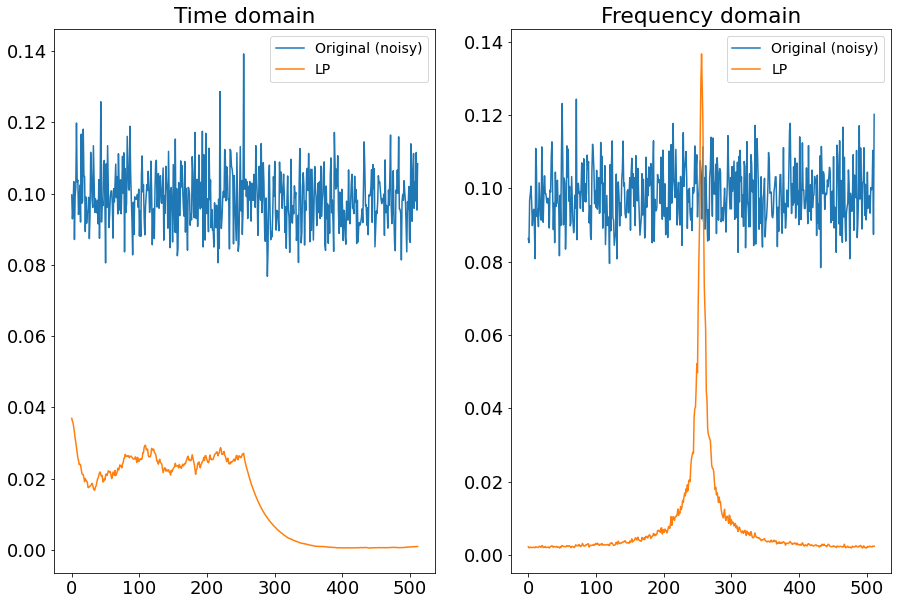

In [63]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
ax1.plot(np.std(noisy_data[:,6,6,0,:],axis=0), label='Original (noisy)')
ax1.plot(np.std(lp_denoised[:,6,6,0,:],axis=0), label='LP')
ax1.set_title('Time domain')
ax1.legend()
ax2.plot(np.std(FID2Spec(noisy_data,axis=4)[:,6,6,0,:],axis=0), label='Original (noisy)')
ax2.plot(np.std(FID2Spec(lp_denoised,axis=4)[:,6,6,0,:],axis=0), label='LP')
ax2.legend()
ax2.set_title('Frequency domain')
plt.show()

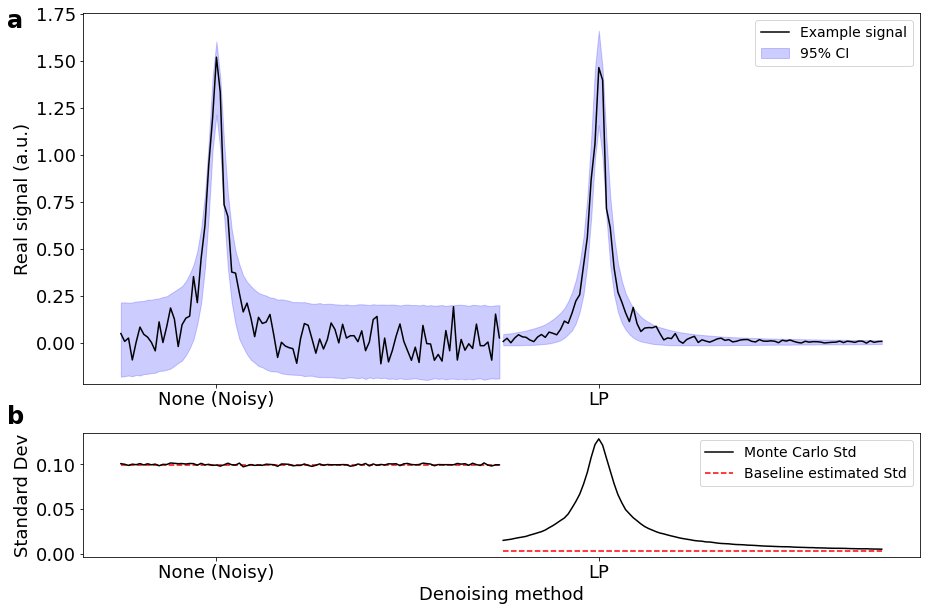

In [26]:
def plot_with_shaded_std(ax,xpos, all_data, xrange, label1=None, label2=None):
    all_data = all_data.copy().reshape(-1,all_data.shape[-1])
    to_plot = FID2Spec(all_data[0])[xrange]
    xindicies = xpos + np.arange(0,len(to_plot))
    ax.plot(xindicies,to_plot.real,'k', label=label1)
    
    mean = np.mean(FID2Spec(all_data,axis=1)[:,xrange], axis=0)
    std = 1.96 * np.std(FID2Spec(all_data,axis=1)[:,xrange], axis=0)
    ax.fill_between(xindicies, mean.real - std, mean.real + std, color='b', alpha=0.2, label=label2)
    
def plot_std(ax,xpos,all_data,xrange,xrange_noise, label1=None, label2=None):
    all_data = all_data.copy().reshape(-1,all_data.shape[-1])
    to_plot = FID2Spec(all_data[0])[xrange]
    xindicies = xpos + np.arange(0,len(to_plot))
    std = np.std(FID2Spec(all_data,axis=1)[:,xrange], axis=0)
    ax.plot(xindicies,std,'k',label=label1)
    std2 = np.std(FID2Spec(all_data,axis=1)[:,xrange_noise])
    ax.hlines(std2,xindicies[0],xindicies[-1],'r',linestyle='--',label=label2)

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,10),gridspec_kw={'height_ratios': [3, 1]})
xrange = 100
xslice = slice(int(256-xrange/4),int(256+3*xrange/4))
plot_with_shaded_std(ax1,0,noisy_data,xslice)
plot_with_shaded_std(ax1,xrange,lp_denoised,xslice, label1='Example signal', label2='95% CI')
ax1.set_xticks([xrange/4, xrange+xrange/4])
ax1.set_xticklabels(['None (Noisy)', 'LP'])
ax1.set_ylim([-0.22,None])
ax1.set_ylabel('Real signal (a.u.)')
ax1.legend(loc=1)
fig.text(0.055, 0.86,'a',fontweight='bold',fontsize=24)

noise_slice = slice(0,50)
plot_std(ax2,0,noisy_data,xslice,noise_slice)
plot_std(ax2,xrange,lp_denoised,xslice,noise_slice, label1='Monte Carlo Std', label2='Baseline estimated Std')
ax2.set_xticks([xrange/4, xrange+xrange/4])
ax2.set_xticklabels(['None (Noisy)', 'LP'])
ax2.set_ylabel('Standard Dev')
ax2.set_xlabel('Denoising method')
ax2.legend()
fig.text(0.055, 0.31,'b',fontweight='bold',fontsize=24)
plt.show()

## Carry out variance estimation on LP hankel matrix according to Chen et al's method

In [53]:
# Redefine the LP denoising function from mrs_denoising.denoising exposing the variance estimation outputs
from mrs_denoising.utils import svd_trunc

def lp(data, r,  W=None):
    '''Run linear-prediction denoising on 3D MRSI data.
    :param np.ndarray data: space-time MRSI data
                      assume dimensions [Nx, Ny, Nz, ..., Nt]
    :param int r: rank threshold for Hankel filtering constraint
    :param int W: Size of 1st Hankel matrix dimension.
        If None, defaults to half of time domain length.
    '''
    data_shape = data.shape
    out = data.copy().reshape(-1, data_shape[-1])
    out_var = data.copy().reshape(-1, data_shape[-1])

    # Loop over all the FIDs and apply
    # Hankel matrix Low-Rank enforcement
    if W is None:
        W = int(out.shape[1] / 2)
    elif W >= out.shape[1]:
        raise ValueError('W must be smaller than the time domain length.')
    K = out.shape[1] - W
    H = np.zeros((W, W+1), dtype=complex)
    for idx, v_data in enumerate(out):
        for wdx in range(W):
            H[wdx, :] = v_data[wdx:(wdx+K+1)]
        H, H_variance, _ = svd_trunc(H, r=r)

        out[idx, :] = np.concatenate((H[0, :], H[1:, -1].T))
        out_var[idx, :] = np.concatenate((H_variance[0, :], H_variance[1:, -1].T))

    return out.reshape(data_shape), out_var.reshape(data_shape)

lp_denoised_var = lp(noisy_data[0,:,:,:,:],1)[1].real
lp_denoised_var *= np.var(noisy_data[0, 4, 4, 0, 300:512])

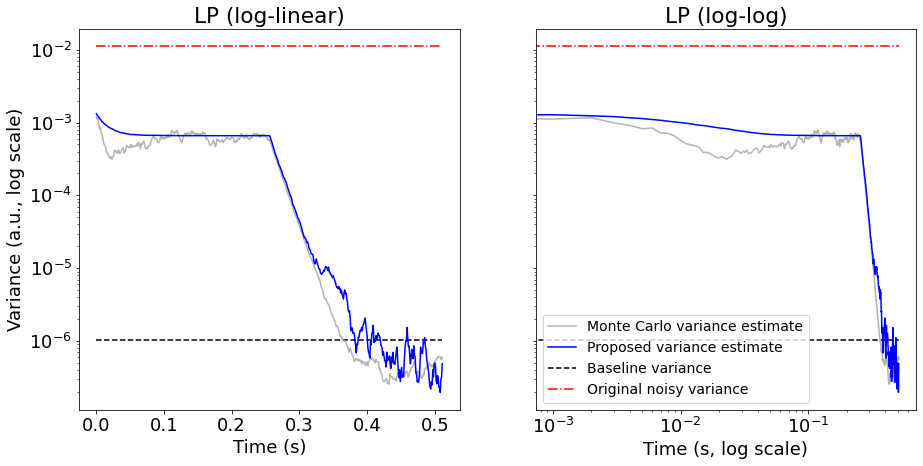

In [73]:
dwelltime = 1 / 1000
points = 512
t_axis = np.arange(0.0, points*dwelltime, dwelltime)

def plot_var2(ax,all_data,est_var,xrange_noise, noisy_var, labels=[None, None, None, None], logx=True):
    std = np.var(all_data[:,4,4,0,:], axis=0)
    std2 = np.var(all_data[0,4,4,0, xrange_noise])
    ax.plot(t_axis, std,color=[0.7, 0.7, 0.7], label=labels[0])
    ax.plot(t_axis, est_var[4,4,0,:],'b',label=labels[1])
    ax.hlines(std2, t_axis[0], t_axis[-1],'k',linestyle='--',label=labels[2])
    ax.hlines(noisy_var, t_axis[0], t_axis[-1],'r',linestyle='-.',label=labels[3])
    ax.set_yscale('log')
    if logx:
        ax.set_xscale('log')

noise_slice = slice(300,512)
noisy_var = np.var(noisy_data[0, 4, 4, 0, 300:512])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7),sharey=True)
plot_var2(ax1,lp_denoised,lp_denoised_var, noise_slice, noisy_var, logx=False)
plot_var2(ax2,lp_denoised,lp_denoised_var, noise_slice, noisy_var,
          labels = ['Monte Carlo variance estimate',
                    'Proposed variance estimate',
                    'Baseline variance',
                    'Original noisy variance'])

ax1.set_ylabel('Variance (a.u., log scale)')
ax1.set_xlabel('Time (s)')
ax2.set_xlabel('Time (s, log scale)')
ax1.set_title('LP (log-linear)')
ax2.set_title('LP (log-log)')
ax2.legend(loc=3)

plt.savefig('lp_variance_estimation.png', bbox_inches='tight', dpi=300)

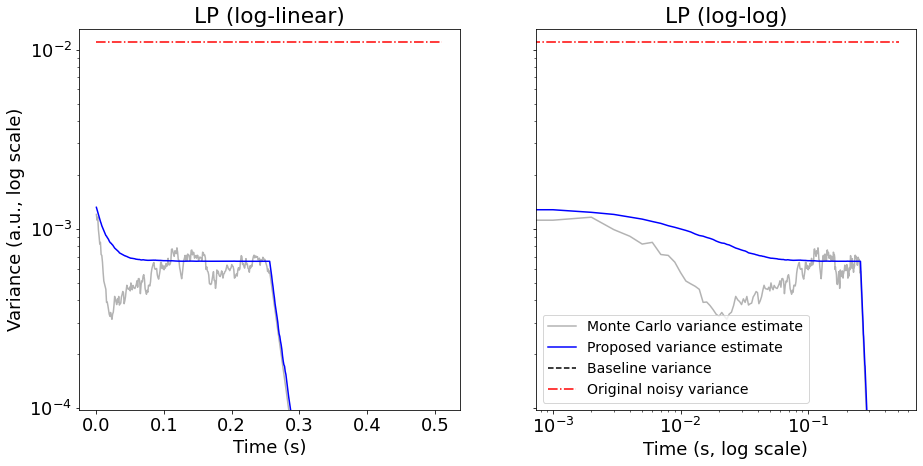

In [81]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7),sharey=True)
plot_var2(ax1,lp_denoised,lp_denoised_var, noise_slice, noisy_var, logx=False)
plot_var2(ax2,lp_denoised,lp_denoised_var, noise_slice, noisy_var,
          labels = ['Monte Carlo variance estimate',
                    'Proposed variance estimate',
                    'Baseline variance',
                    'Original noisy variance'])

ax1.set_ylabel('Variance (a.u., log scale)')
ax1.set_xlabel('Time (s)')
ax2.set_xlabel('Time (s, log scale)')
ax1.set_title('LP (log-linear)')
ax2.set_title('LP (log-log)')
ax2.legend(loc=3)
ax1.set_ylim([0.000098, 0.013])
plt.savefig('lp_variance_estimation_scaled.png', bbox_inches='tight', dpi=300)